In [ ]:
### PACKAGE IMPORT AND VARIABLE DEFINITION ####################################

# import necessary packages
import components as cp
import numpy.random as nr
# import truncating_functions
import numpy as np
import Model
import pandas as pd
import matplotlib.pyplot as plt
import Simulator as sc
import TruncatingFunctions as tr
# from scipy.stats import trapz

# create models
model = Model.Model('Plastic 1985-2016')

RUNS = 10000

startYear = 1985 # starting year
Tperiods = 33 # total number of periods modelled
Speriod = 28 # for 2013
periodRange = np.arange(0,Tperiods)

mylightorange = '#FFEEC9'
myorange      = '#F8D37D'
mydarkorange  = '#B27B00'

print("Modules imported")
print("Number of runs = "+str(RUNS))

In [2]:
### COMPARTMENT DEFINITION ####################################################

collection          = cp.FlowCompartment('Organic waste collection', logInflows=True, logOutflows=True)

anaerobicdigestion  = cp.FlowCompartment('AD plant',           logInflows=True, logOutflows=True, categories=['Treatment'])
composting          = cp.FlowCompartment('Composting plant',   logInflows=True, logOutflows=True, categories=['Treatment'])
windrowcomposting   = cp.FlowCompartment('Windrow composting', logInflows=True, logOutflows=True, categories=['Treatment'])
codigestion         = cp.FlowCompartment('Codigestion',        logInflows=True, logOutflows=True, categories=['Treatment'])

anaerobicdigestionprod = cp.FlowCompartment('Digestate produced from AD',          logInflows=True, logOutflows=True, categories=['Production'])
compostingprod         = cp.FlowCompartment('Compost produced from composting',    logInflows=True, logOutflows=True, categories=['Production'])
windrowcompostingprod  = cp.FlowCompartment('Compost produced from windrows',      logInflows=True, logOutflows=True, categories=['Production'])
codigestionprod        = cp.FlowCompartment('Digestate produced from codigestion', logInflows=True, logOutflows=True, categories=['Production'])

residues            = cp.Sink('Residues',       logInflows=True)
other               = cp.Sink('Other products', logInflows=True)

agriculture         = cp.Sink('Agriculture',  logInflows=True, categories=['Environment'])
horticulture        = cp.Sink('Horticulture', logInflows=True, categories=['Environment'])
gardening           = cp.Sink('Gardening',    logInflows=True, categories=['Environment'])

# create the list of compartments
compartmentList = [collection,
                   anaerobicdigestion,     composting,     windrowcomposting,     codigestion,
                   anaerobicdigestionprod, compostingprod, windrowcompostingprod, codigestionprod,
                   agriculture, horticulture, gardening,
                   residues, other]

# input into model                 
model.setCompartments(compartmentList)

print("Compartments defined")

Compartments defined


C:\Users\dew\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


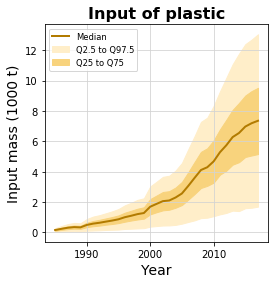

In [3]:
### INPUT DATA ############################################################################################################################################################

# plastic in input: time series
Productiondata = pd.read_csv('C:/Users/dew/Documents/Polybox/Projects/2018.10 Compost/Flows/20190705_STAN_Jupyter_TCDynamics/Jupyter/Input_P.csv',
                             header=None, sep = ';')
# convert to matrix
Productiondata = Productiondata.as_matrix()

# create a triangular distribution around the central imported values, with 100% uncertainty
Input = []
for i in periodRange:
    Input.append(nr.triangular(0,
                               Productiondata[i,1],
                               Productiondata[i,1]*2,
                               RUNS))

model.addInflow(cp.ExternalListInflow(collection, [cp.RandomChoiceInflow(Input[x]) for x in periodRange]))

##### PLOT THE INPUT ##########################

median=[]                                       
q25=[]
q75=[]
qlow=[]
qhigh=[]
for col in Input:
    median.append(np.median(col)/1000)
    q25.append(np.percentile(col,25)/1000)
    q75.append(np.percentile(col,75)/1000)
    qlow.append(np.percentile(col,2.5)/1000)
    qhigh.append(np.percentile(col,97.5)/1000)

# create a new figure
fig = plt.figure('COLL',figsize=(4, 4)) 
plt.xlabel('Year',fontsize=14)
plt.ylabel('Input mass (1000 t)',fontsize=14)
plt.fill_between(periodRange+startYear, qlow, qhigh, color=mylightorange, label="Q2.5 to Q97.5")
plt.fill_between(periodRange+startYear, q25, q75, color=myorange, label="Q25 to Q75")
plt.plot(periodRange+startYear, median, color = mydarkorange, linewidth=2, label='Median')
plt.grid(color='lightgrey')
plt.legend(loc='upper left', fontsize = 'small')
plt.title('Input of plastic', size=16, fontweight="bold")
fig.savefig('Plots/Input_P.pdf', bbox_inches='tight')

In [5]:
### TRANSFER COEFFICIENTS PLASTIC #####################################################

collection.transfers = [cp.StochasticTransfer(tr.TriangTrunc, [0.39,0.146,1,0,1], anaerobicdigestion),
                        cp.StochasticTransfer(tr.TriangTrunc, [0.42,0.146,1,0,1], composting),
                        cp.StochasticTransfer(tr.TriangTrunc, [0.08,0.146,1,0,1], windrowcomposting),
                        cp.StochasticTransfer(tr.TriangTrunc, [0.11,0.146,1,0,1], codigestion)]

composting.transfers = [cp.StochasticTransfer(tr.TriangTrunc, [0.019,1.03,1,0,1], compostingprod, priority=2),
                        cp.ConstTransfer(1, residues, priority=1),
                        cp.ConstTransfer(0, other,    priority=2)]

anaerobicdigestion.transfers = [cp.StochasticTransfer(tr.TriangTrunc, [0.014,1.03,1,0,1], anaerobicdigestionprod, priority=2),
                                cp.ConstTransfer(1, residues, priority=1),
                                cp.ConstTransfer(0, other, priority=2)]

windrowcomposting.transfers = [cp.StochasticTransfer(tr.TriangTrunc, [0.025,1.04,1,0,1], windrowcompostingprod, priority=2),
                               cp.ConstTransfer(1, residues, priority=1),
                               cp.ConstTransfer(0, other, priority=1)]

codigestion.transfers = [cp.StochasticTransfer(tr.TriangTrunc, [0.0028,1.03,1,0,1], codigestionprod, priority=2),
                         cp.ConstTransfer(1, residues, priority=1),
                         cp.ConstTransfer(0, other, priority=1)]


# some priorities are modified because of the truncation-mean translocation problem
compostingprod.transfers = [cp.StochasticTransfer(tr.TriangTrunc, [0.79,0.33,1,0,1], agriculture),
                            cp.StochasticTransfer(tr.TriangTrunc, [0.17,0.33,1,0,1], horticulture),
                            cp.StochasticTransfer(tr.TriangTrunc, [0.04,0.33,1,0,1], gardening)]

anaerobicdigestionprod.transfers = [cp.StochasticTransfer(tr.TriangTrunc, [0.59,0.30,1,0,1], agriculture),
                                    cp.StochasticTransfer(tr.TriangTrunc, [0.34,0.30,1,0,1], horticulture),
                                    cp.StochasticTransfer(tr.TriangTrunc, [0.07,0.30,1,0,1], gardening)]

windrowcompostingprod.transfers = [cp.StochasticTransfer(tr.TriangTrunc, [0.95,0.34,1,0,1], agriculture, priority=1),
                                   cp.StochasticTransfer(tr.TriangTrunc, [0.04,0.33,1,0,1], horticulture, priority=2),
                                   cp.StochasticTransfer(tr.TriangTrunc, [0.005,0.34,1,0,1], gardening, priority=2)]

codigestionprod.transfers = [cp.StochasticTransfer(tr.TriangTrunc, [0.11,0.30,1,0,1], agriculture, priority=2),
                             cp.StochasticTransfer(tr.TriangTrunc, [0.82,0.30,1,0,1], horticulture, priority=1),
                             cp.StochasticTransfer(tr.TriangTrunc, [0.07,0.30,1,0,1], gardening, priority=2)]

In [6]:
#################### RUN THE MODEL: ORGANIC MATTER #######################

# check validity
model.checkModelValidity()
# set up the simulator object
sim = sc.Simulator(RUNS, Tperiods, 2250, True, True) # 2250 is just a seed
# define what model  needs to be run
sim.setModel(model)
# run the model
sim.runSimulation()


Start Simulation
Model: Plastic 1985-2016
Seed Value: 2250
Number of Simulation Runs: 10000
Number of Periods: 33
Progress (in percent):
1,  2,  3,  4,  5,  6,  7,  8,  9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99,  
Simulation complete



In [7]:
# find out the sinks and the stocks of the system
sinks  = sim.getSinks()
stocks = sim.getStocks()

In [17]:
#### PLASTIC FLOWS

# compartment with loggedInflows
loggedInflows = sim.getLoggedInflows() 
# compartment with loggedOutflows
loggedOutflows = sim.getLoggedOutflows()

## display mean ± std for each flow
print 'Logged outflows for year '+str(Speriod+startYear)+':'
print '-----------------------'
print ''
# loop over the list of compartments with loggedoutflows
for Comp in loggedOutflows:
    print 'Flows from ' + Comp.name +':' 
    # in this case name is the key, value is the matrix(data), in this case .items is needed
    for Target_name, value in Comp.outflowRecord.items():
        print ' --> ' + str(Target_name)+ ': Mean = '+str(round(np.mean(value[:,Speriod]),3))+' ± '+str(round(np.std(value[:,Speriod]),3))   
    print''
print '-----------------------'
print ''

Logged outflows for year 2013:
-----------------------

Flows from Organic waste collection:
 --> Composting plant: Mean = 2638.313 ± 1071.395
 --> Codigestion: Mean = 692.387 ± 283.538
 --> AD plant: Mean = 2451.669 ± 996.89
 --> Windrow composting: Mean = 503.373 ± 206.112

Flows from AD plant:
 --> Other products: Mean = 0.0 ± 0.0
 --> Digestate produced from AD: Mean = 34.36 ± 21.026
 --> Residues: Mean = 2417.308 ± 983.112

Flows from Composting plant:
 --> Compost produced from composting: Mean = 50.576 ± 30.469
 --> Other products: Mean = 0.0 ± 0.0
 --> Residues: Mean = 2587.737 ± 1051.341

Flows from Windrow composting:
 --> Compost produced from windrows: Mean = 12.531 ± 7.702
 --> Other products: Mean = 0.0 ± 0.0
 --> Residues: Mean = 490.842 ± 201.077

Flows from Codigestion:
 --> Other products: Mean = 0.0 ± 0.0
 --> Residues: Mean = 690.447 ± 282.748
 --> Digestate produced from codigestion: Mean = 1.94 ± 1.185

Flows from Digestate produced from AD:
 --> Horticulture: Mea

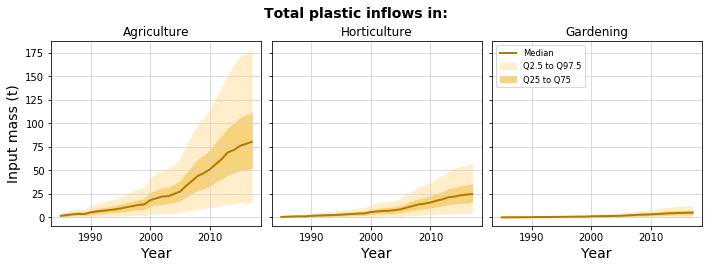

In [9]:
##### PLOT THE INFLOWS ##########################

AgriIn = loggedInflows['Agriculture']
GardIn = loggedInflows['Gardening']
HortIn = loggedInflows['Horticulture']

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(10, 4))

# AGRICULTURE
median=[]                                       
q25=[]
q75=[]
qlow=[]
qhigh=[]
for col in range(0,np.shape(AgriIn)[1]):
    median.append(np.median(AgriIn[:,col]))
    q25.append(np.percentile(AgriIn[:,col],25))
    q75.append(np.percentile(AgriIn[:,col],75))
    qlow.append(np.percentile(AgriIn[:,col],2.5))
    qhigh.append(np.percentile(AgriIn[:,col],97.5))

# create a new figure
axs[0].set_xlabel('Year',fontsize=14)
axs[0].set_ylabel('Input mass (t)',fontsize=14)
axs[0].fill_between(periodRange+startYear, qlow, qhigh, color=mylightorange, label="Q2.5 to Q97.5")
axs[0].fill_between(periodRange+startYear, q25, q75, color=myorange, label="Q25 to Q75")
axs[0].plot(periodRange+startYear, median, color = mydarkorange, linewidth=2, label='Median')
axs[0].grid(color='lightgrey')
axs[0].set_title('Agriculture')

# HORTICULTURE
median=[]                                       
q25=[]
q75=[]
qlow=[]
qhigh=[]
for col in range(0,np.shape(HortIn)[1]):
    median.append(np.median(HortIn[:,col]))
    q25.append(np.percentile(HortIn[:,col],25))
    q75.append(np.percentile(HortIn[:,col],75))
    qlow.append(np.percentile(HortIn[:,col],2.5))
    qhigh.append(np.percentile(HortIn[:,col],97.5))

# create a new figure
axs[1].set_xlabel('Year',fontsize=14)
axs[1].fill_between(periodRange+startYear, qlow, qhigh, color=mylightorange, label="Q2.5 to Q97.5")
axs[1].fill_between(periodRange+startYear, q25, q75, color=myorange, label="Q25 to Q75")
axs[1].plot(periodRange+startYear, median, color = mydarkorange, linewidth=2, label='Median')
axs[1].grid(color='lightgrey')
axs[1].set_title('Horticulture')

# GARDENING
median=[]                                       
q25=[]
q75=[]
qlow=[]
qhigh=[]
for col in range(0,np.shape(GardIn)[1]):
    median.append(np.median(GardIn[:,col]))
    q25.append(np.percentile(GardIn[:,col],25))
    q75.append(np.percentile(GardIn[:,col],75))
    qlow.append(np.percentile(GardIn[:,col],2.5))
    qhigh.append(np.percentile(GardIn[:,col],97.5))

# create a new figure
axs[2].set_xlabel('Year',fontsize=14)
axs[2].fill_between(periodRange+startYear, qlow, qhigh, color=mylightorange, label="Q2.5 to Q97.5")
axs[2].fill_between(periodRange+startYear, q25, q75, color=myorange, label="Q25 to Q75")
axs[2].plot(periodRange+startYear, median, color = mydarkorange, linewidth=2, label='Median')
axs[2].grid(color='lightgrey')
axs[2].legend(loc='upper left', fontsize = 'small')
axs[2].set_title('Gardening')


fig.suptitle('Total plastic inflows in:', size=14, y=0.92, fontweight="bold") # or plt.suptitle('Main title')   
fig.tight_layout()
fig.subplots_adjust(top=0.8,wspace=0.05)

fig.savefig('Plots/P_Inflows_Env.pdf', bbox_inches='tight')

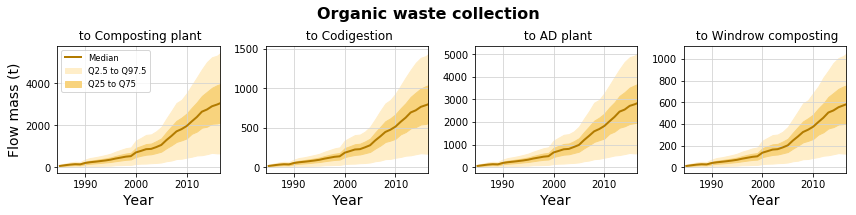

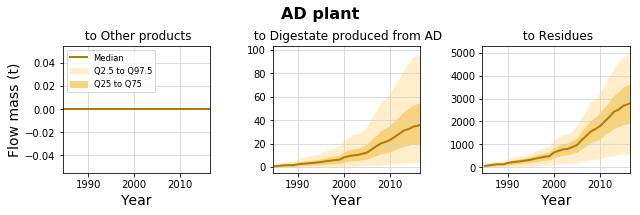

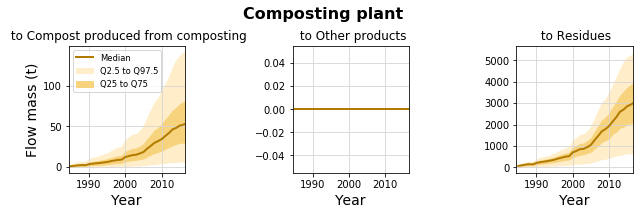

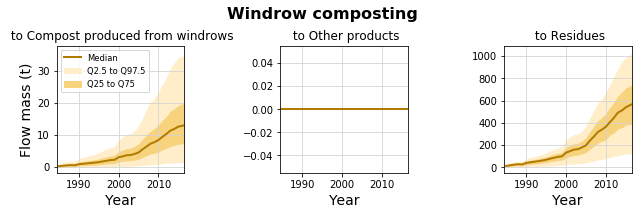

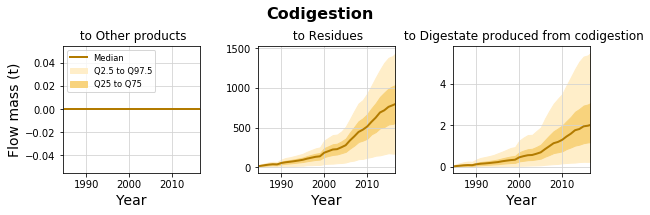

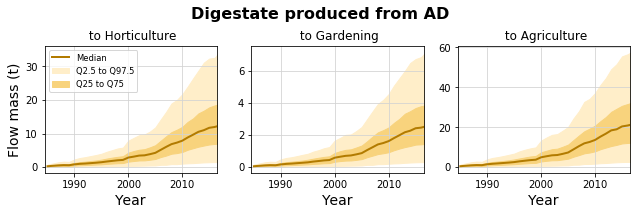

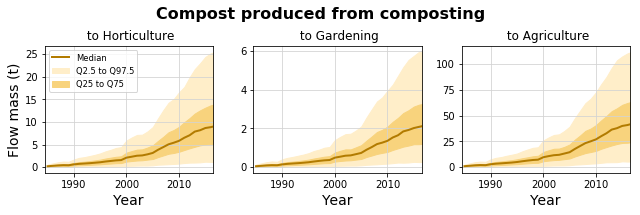

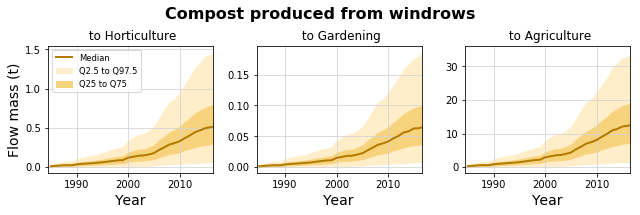

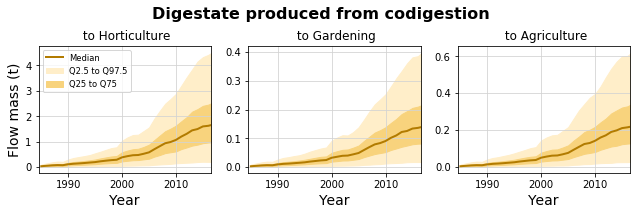

In [10]:
# ONE FIGURE PER OUTFLOW COMPARTMENT
for Comp in loggedOutflows:
    
    nplots = len(Comp.outflowRecord.items())
    fig, axs = plt.subplots(1, int(nplots), figsize=(int(nplots)*3, 3))

    j = 0

    for Target_name, value in Comp.outflowRecord.items():
        
        median=[]                                       
        q25=[]
        q75=[]
        qlow=[]
        qhigh=[]
        
        for i in range(0,np.shape(value)[1]):
            median.append(np.median(value[:,i]))
            q25.append(np.percentile(value[:,i],25))
            q75.append(np.percentile(value[:,i],75))
            qlow.append(np.percentile(value[:,i],2.5))
            qhigh.append(np.percentile(value[:,i],97.5))
        
        # create a new plot
        axs[j].fill_between(periodRange+startYear, qlow, qhigh, color=mylightorange, label="Q2.5 to Q97.5")
        axs[j].fill_between(periodRange+startYear, q25, q75, color=myorange, label="Q25 to Q75")
        axs[j].plot(periodRange+startYear,median, color = mydarkorange, linewidth=2, label='Median')
        axs[j].set_title(' to '+str(Target_name))
        axs[j].set_xlabel('Year',fontsize=14)
        if j==0: axs[j].set_ylabel('Flow mass (t)',fontsize=14)
        axs[j].grid(color='lightgrey')
        #axs[j].rcParams['font.size']=12 # tick's font
        axs[j].set_xlim([1984.5, 2016.5])
        if j==0: axs[j].legend(loc='upper left', fontsize = 'small')
        
        fig.suptitle(str(Comp.name), size=16, y=0.98, fontweight="bold") # or plt.suptitle('Main title')   
        fig.tight_layout()
        plt.subplots_adjust(top=0.8)
        
        plt.savefig('Plots/Flows_P_'+Comp.name+'.pdf')
        
        j = j+1

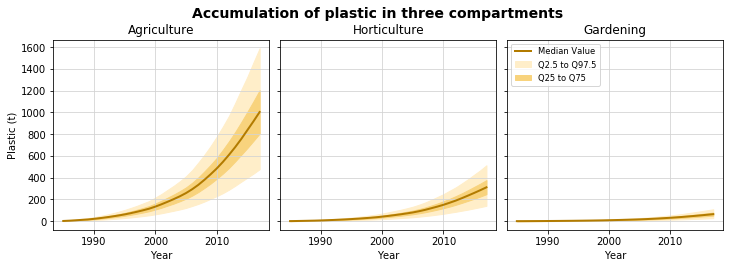

In [11]:
# put the stocked material in an object
StockedMaterial = sim.getAllStockedMaterial()

# create three subplots and save the tuple as two variables
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(12, 3.5))

for ax, comp in zip([ax1, ax2, ax3], ['Agriculture', 'Horticulture', 'Gardening']):
    
    median=[]                                       
    q25=[]
    q75=[]
    qlow=[]
    qhigh=[]
    
    for i in np.arange(0,33):
        median.append(np.median(StockedMaterial[comp][:,i]))
        q25.append(np.percentile(StockedMaterial[comp][:,i],25))
        q75.append(np.percentile(StockedMaterial[comp][:,i],75))
        qlow.append(np.percentile(StockedMaterial[comp][:,i],2.5))
        qhigh.append(np.percentile(StockedMaterial[comp][:,i],97.5))

    ax.fill_between(periodRange+startYear, qlow, qhigh, color=mylightorange, label="Q2.5 to Q97.5")
    ax.fill_between(periodRange+startYear, q25, q75, color=myorange, label="Q25 to Q75")
    ax.plot(periodRange+startYear, median, color = mydarkorange
            , linewidth=2, label='Median Value')
    ax.grid(color='lightgrey')
    ax.set_title(comp)
    ax.set_xlabel('Year')
    if comp == "Agriculture":
        ax.set_ylabel('Plastic (t)')
    if comp == "Gardening":
        ax.legend(loc='upper left', fontsize = 'small')

# reduce the space in horizontal direction
fig.subplots_adjust(wspace=0.05)
# main title
fig.suptitle('Accumulation of plastic in three compartments', fontsize=14, y=1.01, weight='bold')
# export
fig.savefig('Plots/TimeSeries_Stocks_P.pdf', bbox_inches='tight')

In [12]:
# print out the amount accumulated in 2017
# display mean ± std
print 'Amount in sinks for year 2017:'
print '-----------------------'
print ''

data = StockedMaterial['Agriculture'][:,32]
print 'Agriculture: Mean = '+str(round(np.mean(data),0))+' ± '+str(round(np.std(data),0))   

data = StockedMaterial['Horticulture'][:,32]
print 'Horticulture: Mean = '+str(round(np.mean(data),0))+' ± '+str(round(np.std(data),0))   

data = StockedMaterial['Gardening'][:,32]
print 'Gardening: Mean = '+str(round(np.mean(data),0))+' ± '+str(round(np.std(data),0))   

print''

data = StockedMaterial['Agriculture'][:,32] + StockedMaterial['Horticulture'][:,32] + StockedMaterial['Gardening'][:,32]
print 'TOTAL: Mean = '+str(round(np.mean(data),0))+' ± '+str(round(np.std(data),0)) 

print''
print '-----------------------'


Amount in sinks for year 2017:
-----------------------

Agriculture: Mean = 1009.0 ± 287.0
Horticulture: Mean = 315.0 ± 95.0
Gardening: Mean = 65.0 ± 21.0

TOTAL: Mean = 1389.0 ± 387.0

-----------------------


In [13]:
# print out the amount emitted in 2017
# display mean ± std
print 'Amount emitted in year 2017:'
print '-----------------------'
print ''

data = loggedInflows['Agriculture'][:,32]
print 'Agriculture: Mean = '+str(round(np.mean(data),0))+' ± '+str(round(np.std(data),0))   

data = loggedInflows['Horticulture'][:,32]
print 'Horticulture: Mean = '+str(round(np.mean(data),0))+' ± '+str(round(np.std(data),0))   

data = loggedInflows['Gardening'][:,32]
print 'Gardening: Mean = '+str(round(np.mean(data),0))+' ± '+str(round(np.std(data),0))   

print''

data = loggedInflows['Agriculture'][:,32] + loggedInflows['Horticulture'][:,32] + loggedInflows['Gardening'][:,32]
print 'TOTAL: Mean = '+str(round(np.mean(data),0))+' ± '+str(round(np.std(data),0)) 

print''
print '-----------------------'

Amount emitted in year 2017:
-----------------------

Agriculture: Mean = 84.0 ± 42.0
Horticulture: Mean = 26.0 ± 14.0
Gardening: Mean = 5.0 ± 3.0

TOTAL: Mean = 116.0 ± 58.0

-----------------------
